Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [2]:
#Load data
df = pd.read_excel('C:/Users/shrut/Documents/Google Data Analytics/Market Analysis/Online_retail.xlsx')
df.shape

(541909, 9)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   TotalAmount  541909 non-null  float64       
 7   CustomerID   406829 non-null  float64       
 8   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


## Analysis 1: Cohort Analysis to observe retention rate

#### Data Cleaning

In [4]:
#Drop rows with no customer ID
df.dropna(subset=['CustomerID'], inplace=True)
#Delete rows with no invoicedate
df.dropna(subset=['InvoiceDate'], inplace=True)


In [5]:
df.shape

(406829, 9)

In [6]:
# we need just the date for InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
#get month name from InvoiceDate
df['InvoiceMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,TotalAmount,CustomerID,Country,InvoiceMonth
0,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,-168469.60,16446.0,United Kingdom,2011-12
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,-77183.60,12346.0,United Kingdom,2011-01
2,C556445,M,Manual,-1,2011-06-10,38970.00,-38970.00,15098.0,United Kingdom,2011-06
12,C573079,M,Manual,-2,2011-10-27,4161.06,-8322.12,12536.0,France,2011-10
14,C551685,POST,POSTAGE,-1,2011-05-03,8142.75,-8142.75,16029.0,United Kingdom,2011-05


#### Customer Retention Cohort

##### blah

In [7]:
#First month a customer is acquired defined as min InvoiceMonth for each customer
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,TotalAmount,CustomerID,Country,InvoiceMonth,CohortMonth
541902,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20,5.06,7144.72,17450.0,United Kingdom,2011-09,2010-12
541903,551697,POST,POSTAGE,1,2011-05-03,8142.75,8142.75,16029.0,United Kingdom,2011-05,2010-12
541906,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10,649.50,38970.00,15098.0,United Kingdom,2011-06,2011-06
541907,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,77183.60,12346.0,United Kingdom,2011-01,2011-01
541908,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,168469.60,16446.0,United Kingdom,2011-12,2011-05


In [8]:
# Number of months a customer has been with us defined as InvoiceMonth - CohortMonth. 
# We need the .n this is what we get when we don't use it and subtracting datetime objects.
#<4 * MonthEnds>
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,TotalAmount,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
541902,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20,5.06,7144.72,17450.0,United Kingdom,2011-09,2010-12,9
541903,551697,POST,POSTAGE,1,2011-05-03,8142.75,8142.75,16029.0,United Kingdom,2011-05,2010-12,5
541906,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10,649.50,38970.00,15098.0,United Kingdom,2011-06,2011-06,0
541907,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,77183.60,12346.0,United Kingdom,2011-01,2011-01,0
541908,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,168469.60,16446.0,United Kingdom,2011-12,2011-05,7


In [9]:
# create a function to Calculate retention rate as a ratio of number of customers in each cohort to the number of customers in the first cohort
def calc_retention(cohort_df):
    first_month = cohort_df.iloc[:,0]
    retention = round(cohort_df.divide(first_month, axis=0),3) * 100
    return retention

#Create a function to count unique values in cohort and return the pivoted dataframe
def count_unique_cohort(df, cohort_group, cohort_index, cohort_value):
    cohort_data = df.groupby([cohort_group, cohort_index])[cohort_value].apply(pd.Series.nunique).reset_index()
    return cohort_data.pivot(index=cohort_group, columns=cohort_index, values=cohort_value)

#Create a function to count unique values in dataframe
def count_unique(df, cohort_group, cohort_index,cohort_value):
    count = df.groupby([cohort_group,cohort_index])[cohort_value].apply(pd.Series.nunique).reset_index()
    return count



In [10]:
#Create a function to plot the pivoted cohort dataframe into a heatmap
def plot(pivoted_df, xlabel, ylabel, title):
    #cohort_data = df.groupby([cohort_group, cohort_index])[cohort_value].apply(pd.Series.nunique).reset_index()
    #cohort_data = cohort_data.pivot(index=cohort_group, columns=cohort_index, values=cohort_value)
    fig,ax = plt.subplots(1,1,figsize=(18, 8))
    sns.heatmap(pivoted_df, annot=True, fmt='.1f')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.show()


In [11]:
# create retention rate cohort pivot table
retention = count_unique_cohort(df, 'CohortMonth', 'CohortIndex', 'CustomerID')
retention_cohort = calc_retention(retention)

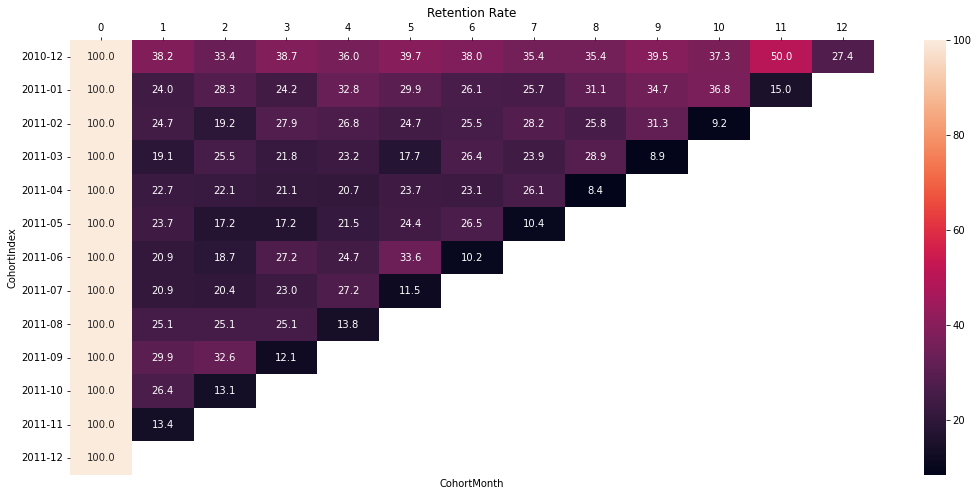

In [12]:
#plot the retention rate cohort pivot table
plot(retention_cohort, 'CohortMonth', 'CohortIndex','Retention Rate')

In [13]:
#Average retention rate for each month across all cohorts
retention_cohort.mean().mean()


31.864579864579866

<font color=blue>_Observation about Retention Rate:_
 _Retention rate is consistently bad, with an average retention rate of 31.86 %_ 
 _2010-12 cohort is the most unique cohort in terms of good performance_
 _Only 13.4 % of customers return the next month in the 2011-11 cohort
 _</font>

<AxesSubplot:xlabel='CohortIndex'>

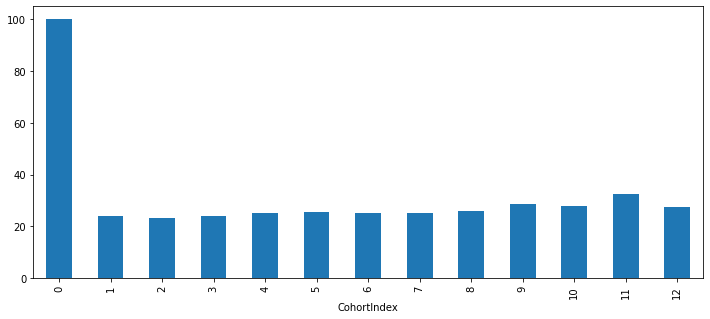

In [14]:
#Plot bar chart and annotate the average retention rate of each cohort index across all cohorts
retention_cohort.mean().plot(kind = 'bar',figsize=(12, 5))

In [15]:
#Number of distinct customers in each cohort
count_unique(df, 'CohortMonth', 'CohortIndex','CustomerID')

,CohortMonth,CohortIndex,CustomerID
0,2010-12,0,948
1,2010-12,1,362
2,2010-12,2,317
3,2010-12,3,367
4,2010-12,4,341
...,...,...,...
86,2011-10,1,93
87,2011-10,2,46
88,2011-11,0,321
89,2011-11,1,43


In [16]:
#Number of distinct orders in each cohort
count_unique(df, 'CohortMonth', 'CohortIndex','InvoiceNo')

,CohortMonth,CohortIndex,InvoiceNo
0,2010-12,0,1708
1,2010-12,1,689
2,2010-12,2,579
3,2010-12,3,753
4,2010-12,4,611
...,...,...,...
86,2011-10,1,167
87,2011-10,2,57
88,2011-11,0,425
89,2011-11,1,55


In [17]:
invoce_pivot_df = count_unique_cohort(df, 'CohortMonth', 'CohortIndex', 'InvoiceNo')

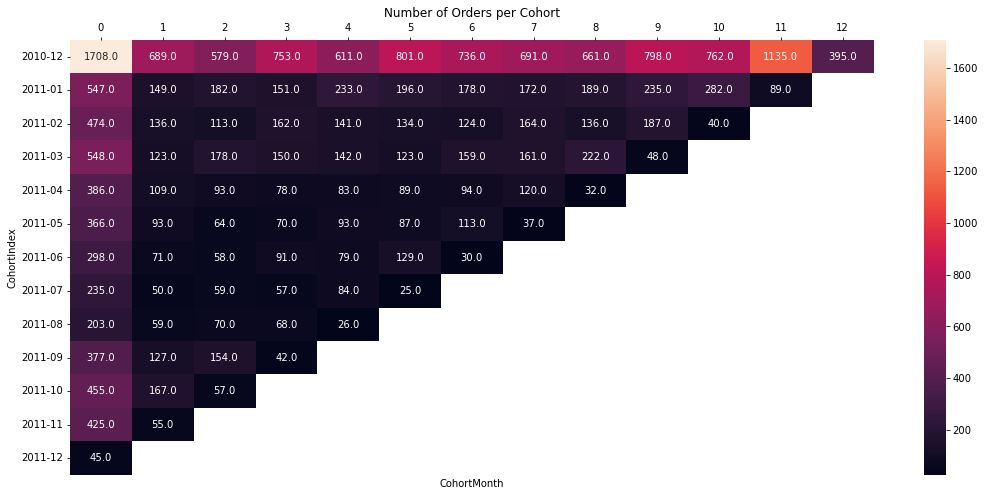

In [18]:
#plot the number of orders per cohort
plot(invoce_pivot_df, 'CohortMonth', 'CohortIndex','Number of Orders per Cohort')

c:\Users\shrut\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


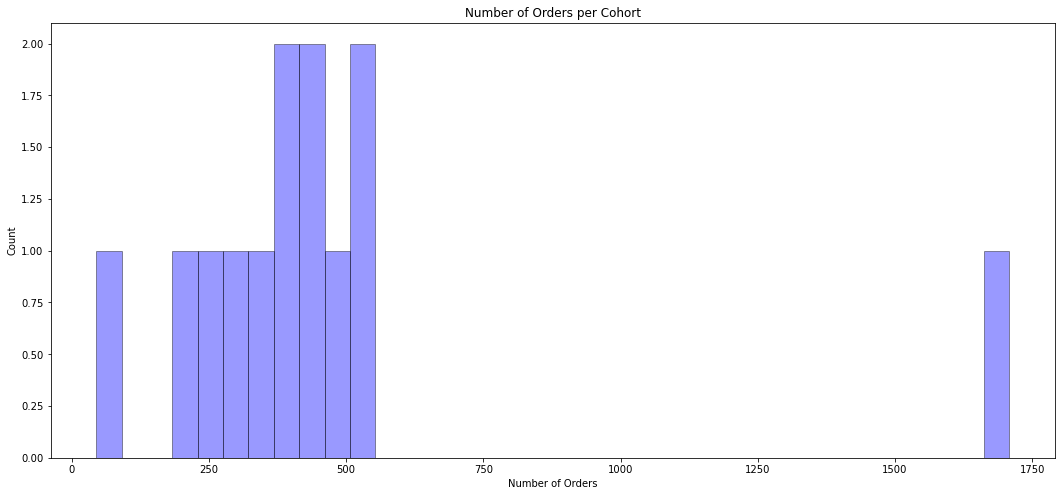

In [19]:
#PLot histogram of number of orders in each cohort
fig,ax = plt.subplots(1,1,figsize=(18, 8))
sns.distplot(invoce_pivot_df.iloc[:,0], hist=True, kde=False,
                bins=int(180/5), color = 'blue',
                hist_kws={'edgecolor':'black'})
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Count')
ax.set_title('Number of Orders per Cohort')
plt.show()



#### Recency, Frequency, Monetary Segmentation

In [20]:
#Current Date defined as the last date in the dataset + 1 day
current_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
#Difference between max InvoiceDate and current Date for each customer in days
df['DaysSinceLastPurchase'] = (pd.to_datetime(current_date) - pd.to_datetime(df['InvoiceDate'])).dt.days
#Create a new column called Frequence defined as the number of orders for each customer
df['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

In [21]:
#Spend quartiles with 4 being the highest spenders and 1 being the lowest
df['SpendQuartile'] = pd.qcut(df['TotalAmount'], q=4, labels=[1,2,3,4])
#Recency quartiles with 4 being most recent and 1 being least recent
df['RecencyQuartile'] = pd.qcut(df['DaysSinceLastPurchase'], q=4, labels=[4,3,2,1])
#Frequency quartiles with 4 being highly frequent and 1 being the least frequent
df['FrequencyQuartile'] = pd.qcut(df['Frequency'], q=4, labels=[1,2,3,4])

In [22]:
#Create a function to calculate RFM score. The higher the score the better the customer.
def rfm_score(df):
    df['RFM_Score'] = df[['RecencyQuartile','FrequencyQuartile','SpendQuartile']].sum(axis = 1)
    return df

In [23]:
#Create RFM segments based on RFM score
def rfm_segment(df):
    df['RFM_Segment'] = df['RFM_Score'].apply(lambda x: 'High Value' if x >= 10 else 'Mid Value' if x >= 6 else 'Low Value')
    return df

In [24]:
#Histogram of RFM score
def rfm_hist(df):
    fig,ax = plt.subplots(1,1,figsize=(18, 8))
    ax.hist(df['RFM_Score'], bins=9, color='blue', edgecolor='black')
    ax.set_xlabel('RFM Score')
    ax.set_ylabel('Number of Customers')
    ax.set_title('RFM Score Distribution')
    plt.show()

In [25]:
#Pie chart of number of customers in each RFM segment
df['RFM_Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='RFM Segments')

KeyError: 'RFM_Segment'

In [ ]:
#How many customers in each RFM segment
df['RFM_Segment'].value_counts().sort_values(ascending=False)

In [ ]:
#RFM segment with the highest spend
df.groupby('RFM_Segment')['TotalAmount'].sum().sort_values(ascending=False)

In [ ]:
#TotalAmount range in mid value segment
df[df['RFM_Segment'] == 'Mid Value']['TotalAmount'].describe()

In [ ]:
df[df['RFM_Segment'] == 'High Value']['TotalAmount'].describe()

#### Survival Analysis